In [12]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [13]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

from b2heavy.FnalHISQMetadata import params as mData

In [24]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

JKFIT = False

In [25]:
ENSEMBLE_LIST = ['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine']
MOMLIST       = ['000','100','200','300','400']
RATIO_LIST    = ['XF','RPLUS','RMINUS','QPLUS']

In [26]:
Rs = []
jk = {}
for ens in ENSEMBLE_LIST:
    jk[ens] = {}
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}
        jk[ens][mom] = {}
        for rat in RATIO_LIST:
            if (mom=='000' and rat!='RPLUS') or (mom!='000' and rat=='RPLUS'):
                continue
            else:
                try:
                    res = read_config_fit(
                        tag  = f'fit3pt_config_{ens}_{rat}_{mom}',
                        path = DATA_2PT,
                        jk   = JKFIT
                    )
                    f0 = res['ratio'][0] if JKFIT else res[-1]['ratio'][0]
                    if JKFIT:
                        jk[ens][mom][rat] = f0
                        r = gv.gvar(f0.mean(),f0.std()*np.sqrt(len(f0)-1))
                    else:
                        r = f0

                except FileNotFoundError:
                    continue
        
            aux[rat] = r
        Rs.append(aux)

df = pd.DataFrame(Rs).set_index(['ensemble','mom'])
df = df.drop(('Coarse-1','400'))
df = df.drop(('Coarse-2','400'))

In [27]:
df

RPLUS            XF        RMINUS        QPLUS
ensemble     mom                                                     
MediumCoarse 000   1.049(52)           NaN           NaN          NaN
             100         NaN   -0.0737(12)   -0.0830(26)   0.9903(25)
             200         NaN   -0.1432(16)   -0.1596(39)   0.9637(68)
             300         NaN   -0.2033(24)   -0.2261(68)   0.9278(85)
             400         NaN   -0.2508(39)   -0.2728(88)    0.893(13)
Coarse-2     000   1.024(11)           NaN           NaN          NaN
             100         NaN   -0.1184(14)   -0.1328(18)   0.9721(28)
             200         NaN   -0.2196(30)   -0.2492(65)    0.922(16)
             300         NaN   -0.2971(70)   -0.3300(97)    0.864(41)
Coarse-1     000  1.0054(37)           NaN           NaN          NaN
             100         NaN   -0.0906(19)   -0.0989(20)   0.9864(47)
             200         NaN   -0.1736(27)   -0.1916(52)    0.962(16)
             300         NaN   -0.2439(48)   -0.2663(66)    0.938(45)
Coarse-Phys  000  1.0164(39)           NaN           NaN          NaN
             100         NaN   -0.0626(10)   -0.0704(23)   0.9957(11)
             200         NaN   -0.1221(13)   -0.1356(31)   0.9786(26)
             300         NaN   -0.1765(17)   -0.1948(41)   0.9483(44)
             400         NaN   -0.2239(26)   -0.2448(39)    0.916(13)
Fine-1       000  1.0335(56)           NaN           NaN          NaN
             100         NaN  -0.07853(97)  -0.08828(99)   0.9825(64)
             200         NaN   -0.1536(14)   -0.1751(16)   0.9484(35)
             300         NaN   -0.2236(23)    -0.263(12)   0.9013(80)
             400         NaN   -0.2816(43)    -0.332(22)    0.867(14)
Fine-Phys    000  1.0225(30)           NaN           NaN          NaN
             100         NaN  -0.06280(81)  -0.06671(80)  0.99614(93)
             200         NaN   -0.1220(10)   -0.1322(10)   0.9787(22)
             300         NaN   -0.1772(15)   -0.1939(16)   0.9515(44)
             400         NaN   -0.2265(24)   -0.2500(51)   0.9222(73)
SuperFine    000  1.0527(19)           NaN           NaN          NaN
             100         NaN  -0.06079(18)  -0.06575(64)  0.99245(63)
             200         NaN  -0.12108(31)  -0.13099(46)   0.9809(14)
             300         NaN  -0.17844(48)  -0.19427(63)   0.9428(15)
             400         NaN  -0.22837(83)   -0.2613(63)   0.9009(25)

In [30]:
rs = df.fillna(1)

In [31]:
def hplus(d):
    return d['RPLUS']**.5 * d['QPLUS'] * (1. - d['RMINUS']*d['XF'])

def hminus(d):
    return d['RPLUS']**.5 * d['QPLUS'] * (1. - d['RMINUS']/d['XF'])


HPLUS  = hplus(rs)
HMINUS = hminus(rs)

In [44]:
rs['QPLUS'] * (1. - rs['RMINUS']*rs['XF'])

ensemble      mom
MediumCoarse  000            0.0
              100     0.9843(25)
              200     0.9417(67)
              300     0.8852(82)
              400      0.832(13)
Coarse-2      000            0.0
              100     0.9568(27)
              200      0.872(15)
              300      0.779(37)
Coarse-1      000            0.0
              100     0.9776(47)
              200      0.930(15)
              300      0.877(42)
Coarse-Phys   000            0.0
              100     0.9914(11)
              200     0.9624(26)
              300     0.9157(43)
              400      0.866(12)
Fine-1        000            0.0
              100     0.9757(63)
              200     0.9229(34)
              300     0.8483(79)
              400      0.786(14)
Fine-Phys     000            0.0
              100    0.99197(93)
              200     0.9630(22)
              300     0.9188(42)
              400     0.8699(70)
SuperFine     000            0.0
              100    0.98

In [51]:
ffs = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        if mom=='000':
            continue

        try:
            hplus  = np.sqrt(rs['RPLUS'].loc[ens,'000']) * rs['QPLUS'].loc[ens,mom] * (1. - rs['RMINUS'].loc[ens,mom]*rs['XF'].loc[ens,mom])
            hminus = np.sqrt(rs['RPLUS'].loc[ens,'000']) * rs['QPLUS'].loc[ens,mom] * (1. - rs['RMINUS'].loc[ens,mom]/rs['XF'].loc[ens,mom])
            w      = (1+rs['XF'].loc[ens,mom]**2)/(1-rs['XF'].loc[ens,mom]**2)
        except KeyError:
            continue
        
        ffs.append({
            'ensemble':ens,
            'mom'     :mom,
            'w'       :w,
            'h+'   :hplus,
            'h-'  :hminus,
        })

ff = pd.DataFrame(ffs).set_index(['ensemble','mom'])

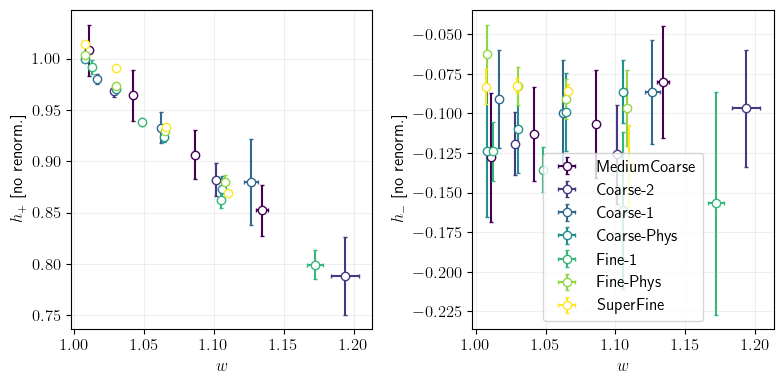

In [66]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)

ens_list = ['MediumCoarse']


color = plt.cm.viridis(np.linspace(0,1,len(ENSEMBLE_LIST)))

for i,ens in enumerate(ENSEMBLE_LIST):
    ax[0].errorbar(
        gv.mean(ff['w' ].loc[ens].values),
        gv.mean(ff['h+'].loc[ens].values),
        xerr = gv.sdev(ff['w' ].loc[ens].values),
        yerr = gv.sdev(ff['h+'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    ax[1].errorbar(
        gv.mean(ff['w' ].loc[ens].values),
        gv.mean(ff['h-'].loc[ens].values),
        xerr = gv.sdev(ff['w' ].loc[ens].values),
        yerr = gv.sdev(ff['h-'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

ax[0].set_ylabel(r'$h_+$ [no renorm.]')
ax[0].set_xlabel(r'$w$')
ax[0].grid(alpha=0.2)

ax[1].legend()
ax[1].set_ylabel(r'$h_-$ [no renorm.]')
ax[1].set_xlabel(r'$w$')
ax[1].grid(alpha=0.2)

plt.tight_layout()